### Clelia Caetano 2023060 (CA2_SEM2)
### MSc. in Data Analytics
### Project Tweets

- The objective of this study is to utilize a large dataset that will be stored in two NoSQL databases. The data will be processed in a Spark environment and Spark SQL language will be used. After eliminating unnecessary data, a comparative performance analysis of the databases will be conducted. 
- Additionally, a sentiment analysis will be performed on the texts extracted from Twitter. Lastly, a time series analysis will be carried out to identify any potential trends or patterns.

In [ ]:
sc.master

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load the libraries
import os
from pyspark.sql import SparkSession

### Initialize Spark Session

In [ ]:
# Create a Spark session with necessary configurations
spark = SparkSession.builder.appName('ProjectTweets') \
                    .config("spark.some_config_option", "config_value") \
                    .getOrCreate()

### Read the Data from HDFS

In [ ]:
# Load the data and create a temporary view in Spark
try:
    # Read the data.csv into Hadoop from HDFS (Hadoop Distributed File System) storage
    data = spark.read.option("header", "true").csv("hdfs://localhost:9000/user/hduser/CA2/ProjectTweets.csv")
    
    # Check if the data was loaded successfully
    if data is not None:
        # Define column names
        new_column_names = ["number", "id_tweet", "date", "query", "user_id", "tweet"]

        # Use the alias method to rename the columns
        for i in range(len(new_column_names)):
            data = data.withColumnRenamed(data.columns[i], new_column_names[i])

        # Create a temporary table from the DataFrame
        data.createOrReplaceTempView("CA2_ProjectTweets")

        # Run Spark SQL queries using the same SparkSession
        data = spark.sql("SELECT * FROM CA2_ProjectTweets") 

        # Display the first 5 rows
        data.show(5)
    else:
        print("Data not loaded successfully.")

except Exception as e:
    print("An error occurred:", str(e))

### Create a Hive database in Spark application

In [ ]:
# Save the DataFrame as a Hive table
data.write.mode("overwrite").saveAsTable("ca2_projecttweets")

In [ ]:
import time
from pyspark.sql import SparkSession

# Create a Spark session with Hive configurations
spark = SparkSession.builder \
    .appName("HiveAnalysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.hadoop.hive.execution.engine", "tez") \
    .config("spark.hadoop.hive.stats.autogather", "true") \
    .config("spark.hadoop.hive.optimize.ppd", "true") \
    .getOrCreate()

# Start measuring time
start_time = time.time()

In [ ]:
# Set the current database
spark.sql("USE ca2_projecttweets")

In [ ]:
# Run a SQL query to select all rows from the table
result = spark.sql("SELECT `number`, `id_tweet`, `date`, `query`, `user_id`, `tweet` FROM ca2_projecttweets")

# Show the first 5 rows
result.show(5)

In [ ]:
# Save the preprocessed data as a new table if needed
result.write.mode("overwrite").saveAsTable("preprocessed_ca2_projecttweets")

In [ ]:
# Access the Hive table and create a DataFrame
data = spark.table("preprocessed_ca2_projecttweets")

# Print the schema
data.printSchema()

In [ ]:
# Check the size of the data
data_size = data.count()
print(f"The size of the dataset is: {data_size} rows")

### Exploratory data analysis (EDA)

In [ ]:
# Calculate the number of unique values in each column.
# List of column names
column_names = ["number", "id_tweet", "date", "query", "user_id", "tweet"]

# Dictionary to store unique value counts
unique_counts = {}

# Iterate through the columns and count unique values
for column_name in column_names:
    unique_values = data.select(column_name).distinct()
    unique_count = unique_values.count()
    unique_counts[column_name] = unique_count

# Print the overall count for each column
print("Overall unique value counts:")
for column, count in unique_counts.items():
    print(f"{column}: {count}")

In [ ]:
# Drop columns that are duplicates and other irrelevant data information
data = data.drop('number', 'id_tweet', 'query', 'user_id')

# Show the updated DataFrame
data.show(5)

### Missing Values

In [ ]:
# Iterate through all columns and print missing value counts
for column_name in data.columns:
    missing_count = data.filter(data[column_name].isNull()).count()
    print(f"Missing values in '{column_name}': {missing_count}")

In [ ]:
# Print the schema
data.printSchema()

In [ ]:
# Call the columns
columns = ["date", "tweet"]

# Set 'tweet' column as the index to convert it as label
data = data.withColumn("label", data["tweet"])

### Descriptive Statistics

In [ ]:
# Compute and interpret the mean, median, quartiles, and standard deviation for "date" and "tweet count"
data.describe(["date"]).show()

### Create a configuration to convert string 'date' into timestamp

In [ ]:
# Config SparkSession from UTC to Pacific Day Time which is the same timezone as the original dataset
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark.conf.set("spark.sql.session.timeZone", "America/Los_Angeles")

# Import libraries to convert
from pyspark.sql.functions import from_unixtime, unix_timestamp
from pyspark.sql.types import TimestampType

# Convert 'date' column in string format to the timestamp
data = data.withColumn("date", from_unixtime(unix_timestamp(data["date"], "E MMM dd HH:mm:ss z yyyy")).cast(TimestampType()))

# Print the 'date' column with the new format
data.select("date").show(5)

### Groupby 'date'

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, count
from pyspark.sql.window import Window

# Group the data by the date without the hour
data = data.withColumn("date_without_hour", to_date(data["date"]))
date_counts = data.groupBy("date_without_hour").agg(count("*").alias("tweet_count"))

# Sort the data by date without hour
date_counts = date_counts.orderBy("date_without_hour")

# Collect the data to the driver
date_counts = date_counts.collect()

# Extract dates and tweet counts for plotting
dates = [str(row.date_without_hour) for row in date_counts]
tweet_counts = [row.tweet_count for row in date_counts]

In [ ]:
# Plot the tweet count
plt.figure(figsize=(12, 6))
plt.bar(dates, tweet_counts)
plt.title("Tweet Count Over Time (Aggregated by Date)")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
from pyspark.sql.functions import col, date_add, datediff
import pyspark.sql.functions as F
from datetime import date, timedelta

# Extract the date part from the 'date' column
data = data.withColumn("date", col("date").cast("date"))

# Sort the DataFrame by date
data = data.orderBy("date")

# Calculate the next date using the lead function
data = data.withColumn("next_date", date_add(col("date"), 1))

# Check if the next date is continuous (no break)
data = data.withColumn("is_continuous", datediff(col("next_date"), col("date")) == 1)

# Create a window specification to order by date
window_spec = Window.orderBy("date")

# Assign a group identifier to continuous sequences
data = data.withColumn("group_id", F.sum(col("is_continuous").cast("int")).over(window_spec))

# Filter only the rows with continuous sequences
continuous_dates = data.filter(col("is_continuous")).select("date").distinct()

# Sort the list in ascending order
continuous_dates = continuous_dates.orderBy("date")

# Get the first and last dates in the DataFrame
first_date = continuous_dates.first().date
last_date = continuous_dates.orderBy(col("date").desc()).first().date

# Print the first and last dates
print("First Date:", first_date)
print("Last Date:", last_date)

# Define the start and end date for the range
start_date = first_date
end_date = last_date

# Generate a list of all dates in the range
date_range = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]

# Convert the list of continuous dates to a Python list
continuous_dates_list = [row.date for row in continuous_dates.collect()]

# Find the dates not in the list
missing_dates = [d for d in date_range if d not in continuous_dates_list]

# Print the missing dates
for missing_date in missing_dates:
    print(missing_date)

# Count the missing days
missing_days_count = len(missing_dates)

# Print the missing days count
print("Missing Days Count:", missing_days_count)

### Outliers

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, count
from pyspark.sql.window import Window

# Group the data by the date without the hour
data = data.withColumn("date_without_hour", to_date(data["date"]))
date_counts = data.groupBy("date_without_hour").agg(count("*").alias("tweet_count"))

# Sort the data by date without hour
date_counts = date_counts.orderBy("date_without_hour")

# Collect the data to the driver
date_counts = date_counts.collect()

# Extract tweet counts for plotting
tweet_counts = [row.tweet_count for row in date_counts]

# Create a box plot with outliers marked
plt.figure(figsize=(10, 6))
plt.boxplot(tweet_counts, vert=False, flierprops=dict(marker='o', markerfacecolor='red', markersize=8))
plt.title("Box Plot of Tweet Counts by Date")
plt.xlabel("Tweet Counts")
plt.grid(True)

plt.show()

In [ ]:
# Display the potential outliers (if any) and print them
outliers = []

q1 = date_counts[0].tweet_count
q3 = date_counts[-1].tweet_count
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

for idx, tweet_count in enumerate(tweet_counts):
    if tweet_count < lower_bound or tweet_count > upper_bound:
        outliers.append((date_counts[idx].date_without_hour, tweet_count))

# Print the potential outliers
print("Potential Outliers:")
for date, count in outliers:
    print(f"Date: {date}, Tweet Count: {count}")

### Initialize Spark Session with Cassandra database

In [ ]:
# Create a Spark session with necessary configurations
spark = SparkSession.builder \
    .appName('CassandraIntegration') \
    .config("spark.cassandra.connection.host", "127.0.0.1") \
    .getOrCreate()

### Read the Data from Cassandra

In [ ]:
# Load the data.csv file
cassandraDF = spark.read.csv("file:///home/hduser/Desktop/CA2_SEM2/activity_from_cassandra.csv", header=True, inferSchema=True)

# Display the first 5 rows
cassandraDF.show(5)

# Measure execution time
start_time = time.time()

In [ ]:
# Print the schema
cassandraDF.printSchema()

In [ ]:
# Check the size of the data
cassandraDF_size = cassandraDF.count()
print(f"The size of the dataset is: {cassandraDF_size} rows")

### Exploratory data analysis (EDA)

In [ ]:
# Import the necessary modules
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.appName("CassandraUniqueValues").getOrCreate()

# List of column names
column_names = ["number", "id_tweet", "date", "query", "user_id", "tweet"]

# Dictionary to store unique value counts
unique_counts = {}

# Iterate through the columns and count unique values
for column_name in column_names:
    unique_values = cassandraDF.select(column_name).distinct()
    unique_count = unique_values.count()
    unique_counts[column_name] = unique_count

# Print the overall count for each column
print("Overall unique value counts:")
for column, count in unique_counts.items():
    print(f"{column}: {count}")

In [ ]:
# Drop columns that are duplicates and other irrelevant data information
cassandraDF = cassandraDF.drop('number', 'id_tweet', 'query', 'user_id')

# Show the updated DataFrame
cassandraDF.show(5)

### Missing Values

In [ ]:
# Iterate through all columns and print missing value counts
for column_name in cassandraDF.columns:
    missing_count = cassandraDF.filter(cassandraDF[column_name].isNull()).count()
    print(f"Missing values in '{column_name}': {missing_count}")

In [ ]:
# Print the schema
cassandraDF.printSchema()

In [ ]:
# Call the columns
columns = ["date", "tweet"]

# Set 'tweet' column as the index to convert it as label
cassandraDF = cassandraDF.withColumn("label", cassandraDF["tweet"])

### Descriptive Statistics

In [ ]:
# Compute and interpret the mean, median, quartiles and standard deviation of the dataset
cassandraDF.describe().show()

### Create a configuration to convert string 'date' into timestamp

In [ ]:
# Config SparkSession from UTC to Pacific Day Time which is the same timezone as the original dataset
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark.conf.set("spark.sql.session.timeZone", "America/Los_Angeles")

# Import libraries to convert
from pyspark.sql.functions import from_unixtime, unix_timestamp
from pyspark.sql.types import TimestampType

# Convert 'date' column in string format to the timestamp
cassandraDF = cassandraDF.withColumn("date", from_unixtime(unix_timestamp(cassandraDF["date"], "E MMM dd HH:mm:ss z yyyy")).cast(TimestampType()))

# Print the 'date' column with the new format
cassandraDF.select("date").show(5)

### Groupby 'date'

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, count
from pyspark.sql.window import Window

# Group the data by the date without the hour
cassandraDF = cassandraDF.withColumn("date_without_hour", to_date(cassandraDF["date"]))
cassandraDF_counts = cassandraDF.groupBy("date_without_hour").agg(count("*").alias("tweet_count"))

# Sort the data by date without hour
cassandraDF_counts = cassandraDF_counts.orderBy("date_without_hour")

# Collect the data to the driver
cassandraDF_counts = cassandraDF_counts.collect()

# Extract dates and tweet counts for plotting
dates = [str(row.date_without_hour) for row in cassandraDF_counts]
tweet_counts = [row.tweet_count for row in cassandraDF_counts]

In [ ]:
# Plot the tweet count with red bars
plt.figure(figsize=(12, 6))
plt.bar(dates, tweet_counts, color='red')  # Set color to red
plt.title("Tweet Count Over Time (Aggregated by Date)")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
from pyspark.sql.functions import col, date_add, datediff
import pyspark.sql.functions as F
from datetime import date, timedelta

# Extract the date part from the 'date' column
cassandraDF = cassandraDF.withColumn("date", col("date").cast("date"))

# Sort the DataFrame by date
cassandraDF = cassandraDF.orderBy("date")

# Calculate the next date using the lead function
cassandraDF = cassandraDF.withColumn("next_date", date_add(col("date"), 1))

# Check if the next date is continuous (no break)
cassandraDF = cassandraDF.withColumn("is_continuous", datediff(col("next_date"), col("date")) == 1)

# Create a window specification to order by date
window_spec = Window.orderBy("date")

# Assign a group identifier to continuous sequences
cassandraDF = cassandraDF.withColumn("group_id", F.sum(col("is_continuous").cast("int")).over(window_spec))

# Filter only the rows with continuous sequences
continuous_dates = cassandraDF.filter(col("is_continuous")).select("date").distinct()

# Sort the list in ascending order
continuous_dates = continuous_dates.orderBy("date")

# Get the first and last dates in the DataFrame
first_date = continuous_dates.first().date
last_date = continuous_dates.orderBy(col("date").desc()).first().date

# Print the first and last dates
print("First Date:", first_date)
print("Last Date:", last_date)

# Define the start and end date for the range
start_date = first_date
end_date = last_date

# Generate a list of all dates in the range
date_range = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]

# Convert the list of continuous dates to a Python list
continuous_dates_list = [row.date for row in continuous_dates.collect()]

# Find the dates not in the list
missing_dates = [d for d in date_range if d not in continuous_dates_list]

# Print the missing dates
for missing_date in missing_dates:
    print(missing_date)

# Count the missing days
missing_days_count = len(missing_dates)

# Print the missing days count
print("Missing Days Count:", missing_days_count)

### Outliers

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, count

# Group the data by the date without the hour
cassandraDF = cassandraDF.withColumn("date_without_hour", to_date(cassandraDF["date"]))
cassandraDF_counts = cassandraDF.groupBy("date_without_hour").agg(count("*").alias("tweet_count"))

# Sort the data by date without hour
cassandraDF_counts = cassandraDF_counts.orderBy("date_without_hour")

# Collect the data to the driver
cassandraDF_counts = cassandraDF_counts.collect()

# Extract tweet counts for plotting
tweet_counts = [row.tweet_count for row in cassandraDF_counts]

# Create a box plot with outliers marked
plt.figure(figsize=(10, 6))
plt.boxplot(tweet_counts, vert=False, flierprops=dict(marker='o', markerfacecolor='red', markersize=8))
plt.title("Box Plot of Tweet Counts by Date for Cassandra")
plt.xlabel("Tweet Counts")
plt.grid(True)

plt.show()

In [ ]:
# Display the potential outliers (if any) and print them
outliers = []

q1 = date_counts[0].tweet_count
q3 = date_counts[-1].tweet_count
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

for idx, tweet_count in enumerate(tweet_counts):
    if tweet_count < lower_bound or tweet_count > upper_bound:
        outliers.append((date_counts[idx].date_without_hour, tweet_count))

# Print the potential outliers
print("Potential Outliers:")
for date, count in outliers:
    print(f"Date: {date}, Tweet Count: {count}")

### Comparison between Hive and Cassandra datasets

In [ ]:
# Get the row count for 'data'
hive_row_count = data.count()

# Get the row count for 'cassandraDF'
cassandra_row_count = cassandraDF.count()

# Calculate the total difference
total_difference = hive_row_count - cassandra_row_count

# Print the row counts and total difference
print("Hive Database Row Count:", hive_row_count)
print("Cassandra Database Row Count:", cassandra_row_count)
print("Total Difference:", total_difference)

In [ ]:
from pyspark.sql.functions import to_date, count
from pyspark.sql.window import Window

# Group the 'data' by the date without the hour
data = data.withColumn("date_without_hour", to_date(data["date"]))
data_date_counts = data.groupBy("date_without_hour").agg(count("*").alias("data_tweet_count"))

# Group 'cassandraDF' by the date without the hour
cassandraDF = cassandraDF.withColumn("date_without_hour", to_date(cassandraDF["date"]))
cassandra_date_counts = cassandraDF.groupBy("date_without_hour").agg(count("*").alias("cassandra_tweet_count"))

# Sort the data by date without hour
data_date_counts = data_date_counts.orderBy("date_without_hour")
cassandra_date_counts = cassandra_date_counts.orderBy("date_without_hour")

# Collect the data to the driver
data_date_counts = data_date_counts.collect()
cassandra_date_counts = cassandra_date_counts.collect()

# Extract tweet counts and calculate the total difference per day
data_tweet_counts = [row.data_tweet_count for row in data_date_counts]
cassandra_tweet_counts = [row.cassandra_tweet_count for row in cassandra_date_counts]
difference_per_day = [data - cassandra for data, cassandra in zip(data_tweet_counts, cassandra_tweet_counts)]

# Print the tweet counts for both datasets and the total difference beside
for date, data_count, cassandra_count, diff in zip(data_date_counts, data_tweet_counts, cassandra_tweet_counts, difference_per_day):
    print(f"Date: {date.date_without_hour}, Hive Count: {data_count}, Cassandra Count: {cassandra_count}, Total Difference: {diff}")

### Normal Distribution Comparison

In [ ]:
import seaborn as sns
from scipy.stats import shapiro
import matplotlib.pyplot as plt

# Extract the tweet counts for both datasets
data_tweet_counts = [row.tweet_count for row in date_counts]
cassandraDF_tweet_counts = [row.tweet_count for row in cassandraDF_counts]

# Create a KDE plot to compare the distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(data_tweet_counts, label='Data', color='blue', shade=True)
sns.kdeplot(cassandraDF_tweet_counts, label='CassandraDF', color='red', shade=True)
plt.title("Tweet Count Distribution Comparison")
plt.xlabel("Tweet Count")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

# Perform the Shapiro-Wilk test to check for normal distribution
data_sw_stat, data_sw_p_value = shapiro(data_tweet_counts)
cassandraDF_sw_stat, cassandraDF_sw_p_value = shapiro(cassandraDF_tweet_counts)

# Print the results of the Shapiro-Wilk test
print("Shapiro-Wilk Test Results:")
print(f"Data dataset: p-value = {data_sw_p_value}, {'Normally Distributed' if data_sw_p_value > 0.05 else 'Not Normally Distributed'}")
print(f"CassandraDF dataset: p-value = {cassandraDF_sw_p_value}, {'Normally Distributed' if cassandraDF_sw_p_value > 0.05 else 'Not Normally Distributed'}")

# Show the plot
plt.show()

### Time execution comparison

In [ ]:
# Stop measuring time
end_time = time.time()
execution_time = end_time - start_time

print(f"Hive Execution Time: {execution_time} seconds")

In [ ]:
# Stop measuring time
end_time = time.time()
execution_time = end_time - start_time

print(f"Cassandra Execution Time: {execution_time} seconds")

#### Note: A Comparison of Datasets between Hive and Cassandra.

- While these NoSQL datasets were generated from the original data provided as a study tool, a noticeable difference can be observed in the total number of rows between them:
    - Hive Database Row Count: 1599999
    - Cassandra Database Row Count: 1036130
    - Total Difference: 563869.
- The Hive database was created through HDFS, and was built using the original file, employing Spark commands in the Jupyter notebook. 
- In contrast, the Cassandra database was created within the Cassandra prompt using commands related to tables, keyspaces, and the COPY FROM function, where the original file was utilized.

### Modelling & Natural Language Processing (NLP):

In [ ]:
# Check the DataFrame
data.show(5)

In [ ]:
import pandas as pd
from pyspark.sql.functions import concat, lit

# Initialize a Spark session
spark = SparkSession.builder.appName("TweetPreprocessing").getOrCreate()

# Recall the HIVE DataFrame 

# First, create a new column 'tweet' with the same data as 'label'
data = data.withColumn("tweet", data["label"])

# Drop the specified columns
columns_to_drop = ["date_without_hour", "next_date", "is_continuous", "group_id"]
data = data.drop(*columns_to_drop)

# Now, remove the 'label' column and put the text in quotation marks
data = data.drop("label")
data = data.withColumn("tweet", concat(lit('"'), data["tweet"], lit('"')))

# Show the data
data.show(5)

# Save the DataFrame as TweetPreProcessing in Parquet format
data.write.mode("overwrite").save("TweetPreProcessing", format="parquet")

# Convert the Spark DataFrame to a Pandas DataFrame and name it 'df'
df = spark.read.parquet("TweetPreProcessing").toPandas()

# Save the Pandas DataFrame to a CSV file
df.to_csv('processed_data.csv', index=False)

### Sentiment Analysis on ProjectTweets

In [ ]:
# !pip install pandas langdetect

In [ ]:
# Import the necessary libraries
from langdetect import detect

# Initialize a Spark session
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

# Display the first 5 rows of the Pandas DataFrame
df.head(5)

In [ ]:
# Check the shape of the Pandas DataFrame
df.shape

### Convert tweets into sentiments

In [ ]:
#!pip install vaderSentiment

In [1]:
import pandas as pd
import seaborn as sns

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Check if the file exists before reading
file_path = '/home/hduser/Desktop/CA2_SEM2/processed_data.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
else:
    print(f"Error: '{file_path}' not found.")
    # Exit the script or handle the error as needed

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment polarity
def get_sentiment(text):
    compound_score = analyzer.polarity_scores(text)['compound']
    return 'positive' if compound_score >= 0.05 else 'negative' if compound_score <= -0.05 else 'neutral'

# Apply the function to the 'tweet' column
df['sentiment'] = df['tweet'].apply(get_sentiment)

# Display the DataFrame with sentiment
print(df)

               date                                              tweet  \
0        2009-06-02              "English exam today heh cba with it "   
1        2009-06-02  "is at the doctors  lets hope i havent done an...   
2        2009-06-02  "Still terribly upsetting but actually not as ...   
3        2009-06-02                          "@SdPriceless yea. sus. "   
4        2009-06-02  "@JGDerron Sounds like we are on the same page...   
...             ...                                                ...   
1599994  2009-06-25  "Sick  Spending my day laying in bed listening...   
1599995  2009-06-25                                  "Gmail is down? "   
1599996  2009-06-25                    "rest in peace Farrah! So sad "   
1599997  2009-06-25  "@Eric_Urbane Sounds like a rival is flagging ...   
1599998  2009-06-25  "has to resit exams over summer...  wishes he ...   

        sentiment  
0        negative  
1        positive  
2        positive  
3         neutral  
4        po

In [3]:
# Count the occurrences of each sentiment
sentiment_counts = df['sentiment'].value_counts()

# Display the count of each sentiment
print(sentiment_counts)

sentiment
positive    747324
neutral     437375
negative    415300
Name: count, dtype: int64


/home/hduser/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hduser/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hduser/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<AxesSubplot:xlabel='sentiment', ylabel='count'>

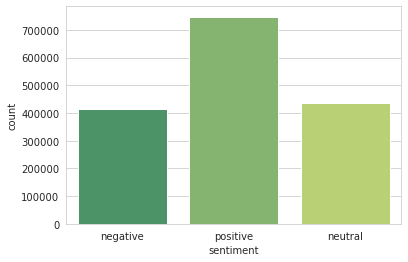

In [4]:
# Plot the Sentiment visualization graph
sns.set_style('whitegrid')
sns.countplot(x='sentiment',data=df, palette='summer')

In [5]:
# Data Preprocessing
df_positive = df[df['sentiment'] == 'positive'][0:8000]
df_neutral = df[df['sentiment'] == 'neutral']
df_negative = df[df['sentiment'] == 'negative']

# Sample negative and neutral dataset and create the final dataframe
df_neutral_over = df_neutral.sample(8000, replace=True)
df_negative_over = df_negative.sample(8000, replace=True)

df = pd.concat([df_positive, df_neutral_over, df_negative_over], axis=0)

In [6]:
# Text Preprocessing**

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from string import punctuation

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    no_punctuation = ''.join([char for char in text if char not in string.punctuation])
    processed_text = ' '.join([word for word in no_punctuation.split() if word.lower() not in stop_words])
    return processed_text

# Apply the preprocessing function directly on the 'tweet' column
df['tweet review'] = df['tweet'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Visualize Tweet Review with Sentiment

df = df[['tweet review', 'sentiment']]
df.head()

df.shape



(24000, 2)

In [8]:
# Apply One hot encoding on negative, neutral, and positive**

one_hot = pd.get_dummies(df["sentiment"])
df.drop(['sentiment'], axis=1, inplace=True)
df = pd.concat([df, one_hot], axis=1)

# Convert boolean columns to integers (0 and 1)
df['negative'] = df['negative'].astype(int)
df['neutral'] = df['neutral'].astype(int)
df['positive'] = df['positive'].astype(int)

df.head()

,tweet review,negative,neutral,positive
1,doctors lets hope havent done anything serious...,0,0,1
2,Still terribly upsetting actually awful true f...,0,0,1
4,JGDerron Sounds like page tonight,0,0,1
7,4everBrandy tryin 2 show fav artist LUV Ill ba...,0,0,1
10,overtime wil busy period ever end Extra cash g...,0,0,1


In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchtext.vocab import GloVe
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import torch.nn.functional as F

# Apply Train Test Split
X = df['tweet review'].values
y = df.drop('tweet review', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Tokenize your text data (simple example using CountVectorizer)
vect = CountVectorizer()
X_train_counts = vect.fit_transform(X_train)
X_test_counts = vect.transform(X_test)

In [10]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_counts.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_counts.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Assuming y_train is one-hot encoded
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)  # Assuming y_test is one-hot encoded

# Define the DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained word embeddings (GloVe in this example)
embedding_dim = 100  # Adjust based on the dimensions of the chosen pre-trained embeddings
glove = GloVe(name='6B', dim=embedding_dim)

# Simple neural network model with linear layer
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, output_size)

    def forward(self, x):
        output = self.fc(x)
        return output

# Instantiate the model
input_dim = X_train_tensor.shape[1]  # Adjust based on the dimensions of the input data
output_size = len(y_train[0])  # Adjust based on the actual number of classes in the target variable
model = SimpleClassifier(input_dim, output_size)

# Define the loss function and optimizer
criterion = F.binary_cross_entropy_with_logits
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [12]:
# Training loop
epochs = 100  # You can set this to any desired number
verbose = 1

# Lists to store the training loss and validation accuracy for each epoch
train_loss_values = []
validation_accuracy_values = []

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training loop
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation accuracy calculation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        if verbose:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.4f}')

        # Append values for plotting
        train_loss_values.append(loss.item())
        validation_accuracy_values.append(accuracy)  

Epoch 1/100, Loss: 0.6064, Validation Accuracy: 2.0374
Epoch 2/100, Loss: 0.5775, Validation Accuracy: 2.0776
Epoch 3/100, Loss: 0.5046, Validation Accuracy: 2.1251
Epoch 4/100, Loss: 0.4970, Validation Accuracy: 2.1790
Epoch 5/100, Loss: 0.5033, Validation Accuracy: 2.2457
Epoch 6/100, Loss: 0.4360, Validation Accuracy: 2.3168
Epoch 7/100, Loss: 0.3767, Validation Accuracy: 2.3629
Epoch 8/100, Loss: 0.4001, Validation Accuracy: 2.4019
Epoch 9/100, Loss: 0.3950, Validation Accuracy: 2.4281
Epoch 10/100, Loss: 0.3469, Validation Accuracy: 2.4500
Epoch 11/100, Loss: 0.3540, Validation Accuracy: 2.4656
Epoch 12/100, Loss: 0.3091, Validation Accuracy: 2.4781
Epoch 13/100, Loss: 0.3106, Validation Accuracy: 2.4917
Epoch 14/100, Loss: 0.3094, Validation Accuracy: 2.5001
Epoch 15/100, Loss: 0.2397, Validation Accuracy: 2.5056
Epoch 16/100, Loss: 0.2856, Validation Accuracy: 2.5107
Epoch 17/100, Loss: 0.2683, Validation Accuracy: 2.5175
Epoch 18/100, Loss: 0.3311, Validation Accuracy: 2.5221
E

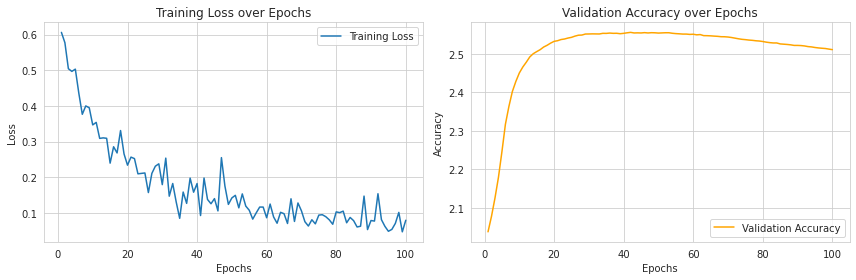

In [13]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 4))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), validation_accuracy_values, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

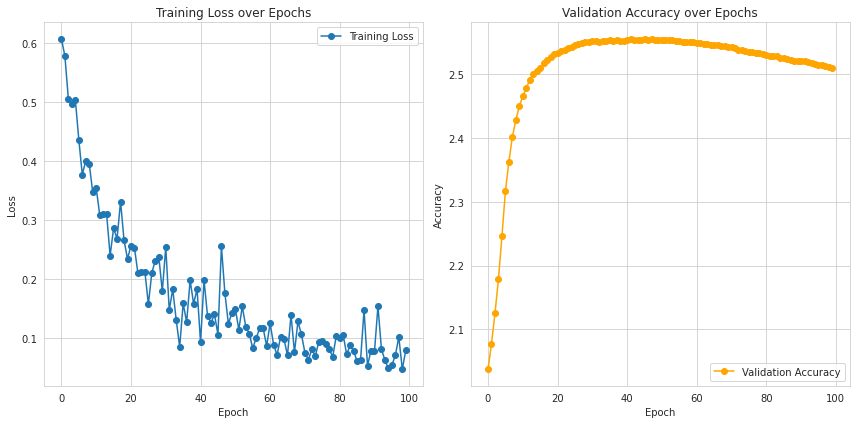

In [14]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Training Loss', marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(validation_accuracy_values, label='Validation Accuracy', marker='o', color='orange')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Evaluation of Model

In [20]:
# Set the model in evaluation mode
model.eval()  

with torch.no_grad():
    correct = 0
    total = 0
    total_loss = 0.0  # Added to accumulate the total loss

    for inputs, labels in test_loader:  # Use the test_loader instead
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # Assuming you have a criterion defined
        total_loss += loss.item()

        predicted = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    average_loss = total_loss / len(test_loader)  # Compute the average loss

    print('Test loss:', average_loss)
    print('Test accuracy:', accuracy)


Test loss: 0.4407244037210414
Test accuracy: 2.5106944444444443


# Lists to store the training loss and validation accuracy for each epoch
train_loss_values = []
validation_loss_values = []  # Add this line
train_accuracy_values = []
validation_accuracy_values = []

# Training loop
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation loss and accuracy calculation
    model.eval()
    with torch.no_grad():
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            predicted = torch.round(torch.sigmoid(outputs))
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = train_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # Validation loss and accuracy calculation
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = torch.round(torch.sigmoid(outputs))
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(test_loader)
        val_accuracy = correct_val / total_val

        if verbose:
            print(f'Epoch {epoch + 1}/{epochs}, '
                  f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
                  f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # Append values for plotting
        train_loss_values.append(train_loss)
        validation_loss_values.append(val_loss)
        train_accuracy_values.append(train_accuracy)
        validation_accuracy_values.append(val_accuracy)

In [15]:
### Prediction

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    new_data = ...  # Replace with the new data
    predicted_labels = model(new_data)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not ellipsis

In [ ]:
preds.shape

### References:

• https://github.com/apache/hive

• https://cassandra.apache.org/doc/latest/cassandra/cql/ddl.html

• Cassandra: The Definitive Guide, (Revised) Third Edition, 3rd Edition, Jeff Carpenter, Eben Hewitt,
O'Reilly Media, Inc., January 2022.